# Software evaluation

In this software evaluation we will evaluate quantitively which is the best metric distance in order to compute our mfccs similarity. Following, we will evaluate if the slices are well cut given the onsets and listen if the best given similar slice sounds as similar as the ground truth.

In [1]:
import essentia
import numpy as np
from essentia.standard import *
import IPython
import matplotlib.pyplot as plt
from matplotlib import cm

class AudioExtractor:

    def __init__(self,loop):
        self.loop = loop
        self.chopList = []
        self.fs = 44100
        self.w_onset = 'hann'
        self.mfccs = []
        self.w_mfcc = 'blackmanharris62'

    def __call__(self):
        return self.chopList

    def get_onsets(self):
        od = OnsetDetection(method='hfc')

        w = Windowing(type=self.w_onset)
        fft = FFT()  # this gives us a complex FFT
        c2p = CartesianToPolar()  # and this turns it into a pair (magnitude, phase)
        pool = essentia.Pool()

        # Computing onset detection functions.
        for frame in FrameGenerator(self.loop, frameSize=1024, hopSize=512):
            mag, phase, = c2p(fft(w(frame)))
            pool.add('features.hfc', od(mag, phase))

        onsets = Onsets()
        onsets_hfc_seconds = onsets(essentia.array([pool['features.hfc']]), [1])

        onsets_hfc_samples = onsets_hfc_seconds * self.fs #retun
        return onsets_hfc_samples, onsets_hfc_seconds


    def get_slices(self,onsets_hfc):
        onsets_hfc = onsets_hfc[0]  # onset stamps in samples
        for onset in range(len(onsets_hfc) - 1):
            self.chopList.append(self.loop[int(onsets_hfc[onset]):int((onsets_hfc[onset + 1]))])


    def extract_mfcc(self,slice):
        w = Windowing(type=self.w_mfcc)
        spectrum = Spectrum()
        mfcc = MFCC()
        mfcc_sin = []
        for frame in FrameGenerator(slice, frameSize=2048, hopSize=1024):
            mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
            mfcc_sin.append(mfcc_coeffs)
        mfcc_sin = essentia.array(mfcc_sin).T
        mfcc_sin = np.mean(mfcc_sin,axis=1)
        self.mfccs.append(mfcc_sin)

## Load audio files

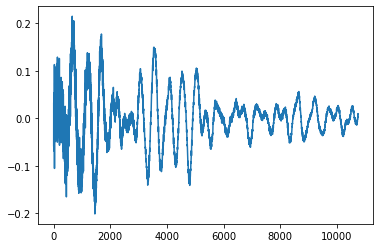

[array([-8.4649310e+02,  8.2925362e+01,  4.2172260e+01,  6.2390766e+01,
        3.1184351e+01,  2.6074347e+01,  3.1582392e+01,  2.1393997e+01,
        1.1251088e+01,  5.5396657e+00,  2.3744781e+00,  1.6691050e-02,
       -1.8080955e+00], dtype=float32)]


In [144]:
audio_loop1 = MonoLoader(filename='../loops/audio1.wav')()
loop1 = AudioExtractor(audio_loop1)
onsets_hfc = loop1.get_onsets() #compute onsets
loop1.get_slices(onsets_hfc) #slice the audio

# chopList contain the list of slices, separately
slice_loop1 = loop1.chopList[3] #get single slice

plt.plot(slice_loop1) #plot single slice
plt.show()

loop1.extract_mfcc(slice_loop1) #extract mfccs
print(loop1.mfccs)

In [145]:
IPython.display.Audio(slice_loop1, rate=44100)

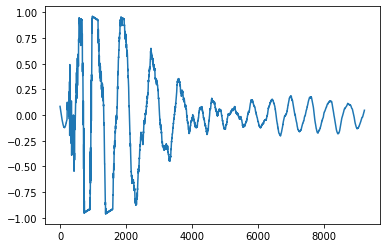

[array([-7.8294830e+02,  1.3752693e+02,  3.5935131e+01,  6.0289352e+01,
        1.6616484e+01,  2.1760408e+01,  1.9681538e+01,  1.2944900e+01,
        8.6646090e+00,  9.0600672e+00,  7.5043077e+00,  3.9323447e+00,
        6.7128390e-01], dtype=float32)]


In [149]:
audio_loop2 = MonoLoader(filename='../loops/audio2.wav')()
loop2 = AudioExtractor(audio_loop2)
onsets_hfc = loop2.get_onsets() #compute onsets
loop2.get_slices(onsets_hfc) #slice the audio

# chopList contain the list of slices, separately
slice_loop2 = loop2.chopList[22] #get single slice

plt.plot(slice_loop2) #plot single slice
plt.show()

loop2.extract_mfcc(slice_loop2) #extact mfccs
print(loop2.mfccs)

In [148]:
IPython.display.Audio(slice_loop2, rate=44100)

## Distance evaluation between audio1 and audio2

In [16]:
from scipy.spatial.distance import cosine, euclidean, cityblock, hamming, chebyshev
from scipy.spatial import minkowski_distance
from sklearn.metrics import jaccard_score

## Normalize distance

In [194]:
#Main loop information audio1
audio_loop1 = MonoLoader(filename='../loops/audio1.wav')()
loop1 = AudioExtractor(audio_loop1)
onsets_hfc = loop1.get_onsets() #compute onsets
loop1.get_slices(onsets_hfc) #slice the audio
slice_loop1 = loop1.chopList[20] #get single slice
loop1.extract_mfcc(slice_loop1) #extract mfccs

#Slave loop information audio2
audio_norm_loop2 = MonoLoader(filename='../loops/audio2.wav')()
norm_loop2 = AudioExtractor(audio_norm_loop2)
onsets_hfc = norm_loop2.get_onsets() #compute onsets
norm_loop2.get_slices(onsets_hfc) #slice the audio

euclidean_list_mfccs = []
distances_list = []
for i in range(0, len(norm_loop2.chopList)):
    curr_slice = norm_loop2.chopList[i] #current slice
    norm_loop2.extract_mfcc(curr_slice) 
    euclidean_list_mfccs.append(norm_loop2.mfccs) #add mfccs of each slice to list
    dist = cosine(loop1.mfccs, euclidean_list_mfccs[0][i]) # compute distances of each slice
    distances_list.append(dist)

#Get normalized value of slice 20 from slave loop comçpared to slice 1 from main loop
normalized_values = []
for i in range(0, len(norm_loop2.chopList)):
    norm_values = (distances_list[i] - min(distances_list))/(max(distances_list) -  min(distances_list)) * 10
    #print("Normalized value for slice {}:".format(i), norm_values)
    normalized_values.append(norm_values)
    
print("Most similar slice is", normalized_values.index(min(normalized_values)), "with", min(normalized_values))
print("Less similar slice is", normalized_values.index(max(normalized_values)), "with", max(normalized_values))

Most similar slice is 34 with 0.0
Less similar slice is 44 with 10.0


### Original slice

In [183]:
main_loop1 = loop1.chopList[20] #get single slice
IPython.display.Audio(main_loop1, rate=44100)

### Most similar

In [195]:
slave_loop2 = loop2.chopList[34] #get single slice
IPython.display.Audio(slave_loop2, rate=44100)

### Less similar

In [196]:
slave_loop3 = loop2.chopList[44] #get single slice
IPython.display.Audio(slave_loop3, rate=44100)

## Visual representation

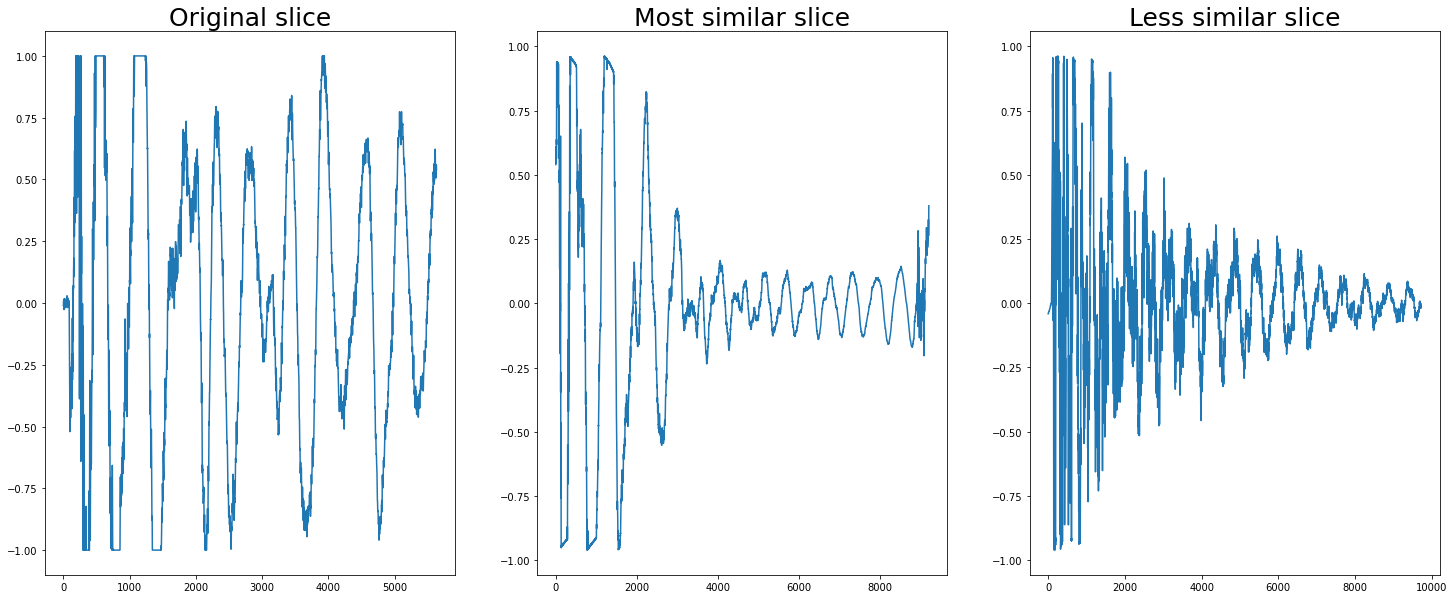

In [197]:
fig = plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.plot(main_loop1) 
plt.title("Original slice", fontsize = 25)
plt.subplot(1,3,2)
plt.plot(slave_loop2) 
plt.title("Most similar slice", fontsize = 25)
plt.subplot(1,3,3)
plt.plot(slave_loop3) 
plt.title("Less similar slice", fontsize = 25)
plt.show()

## Same slice

In [131]:
dist_cosine = cosine(loop1.mfccs, loop1.mfccs)
dist_euclidean = euclidean(loop1.mfccs, loop1.mfccs)
dist_cityblock = cityblock(loop1.mfccs, loop1.mfccs)
dist_hamming = hamming(loop1.mfccs, loop1.mfccs)
dist_chebyshev = chebyshev(loop1.mfccs, loop1.mfccs)

print("Cosine distance:", dist_cosine)
print("Euclidean distance:", dist_euclidean)
print("Manhattan distance:", dist_cityblock)
print("Hamming distance:", dist_hamming)
print("Chebyshev distance:", dist_chebyshev)

Cosine distance: 0.0
Euclidean distance: 0.0
Manhattan distance: 0.0
Hamming distance: 0.0
Chebyshev distance: 0.0


We observe how, for different metric distances we obtain that the distance is 0 for the same slice. Thus, it works!

## Most similar slice 

In [132]:
dist_cosine = cosine(loop1.mfccs, loop2.mfccs)
dist_euclidean = euclidean(loop1.mfccs, loop2.mfccs)
dist_cityblock = cityblock(loop1.mfccs, loop2.mfccs)
dist_hamming = hamming(loop1.mfccs, loop2.mfccs)
dist_chebyshev = chebyshev(loop1.mfccs, loop2.mfccs)

print("Cosine distance:", dist_cosine)
print("Euclidean distance:", dist_euclidean)
print("Manhattan distance:", dist_cityblock)
print("Hamming distance:", dist_hamming)
print("Chebyshev distance:", dist_chebyshev)

Cosine distance: 0.01002192497253418
Euclidean distance: 133.88792419433594
Manhattan distance: 319.05872
Hamming distance: 1.0
Chebyshev distance: 98.61957


We can observe how the Manhattan Distance gives us the highest value, this is due to the fact that is does not represent optimal distance in the case of floating attributes in our dataset. Therefore, we can rule out Manhattan distance.

On the other hand, we can see how the Hamming distance gives us always the same value for different slices, 1.0 due to the fact that works with binary frequencies. We can rule out Hamming distance too.

Euclidean distance is not that effective for high dimensional data, also, it's essential to normalize the input feature in order to avoid the distance computed to get skewed.

#### Essentia - Cover Song Identification

Now let's try to compute the distance using HPCP, ChromaCrossSimilarity and CoverSongSimilarity, which are open-source algorithms from Essentia.

In [182]:
from essentia.pytools.spectral import hpcpgram

In [239]:
main_hpcp = hpcpgram(slice_loop1, sampleRate = 44100) #get slice
loop1_hpcp = hpcpgram(slice_loop2, sampleRate = 44100)

In [343]:
crp = ChromaCrossSimilarity(frameStackSize=3, 
                                 frameStackStride=1, 
                                 binarizePercentile=0.095,
                                 oti=True)

false_slices = crp(main_hpcp, loop1_hpcp) #different slices
true_slices = crp(main_hpcp, main_hpcp) #same slice

In [344]:
score_matrix, distance = CoverSongSimilarity(disOnset=0.5, 
                                                  disExtension=0.5, 
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(false_slices)

print("Cover song similarity distance between false slices:", distance)

Cover song similarity distance between false slices: inf


In [345]:
score_matrix, distance = CoverSongSimilarity(disOnset=0.5, 
                                                  disExtension=0.5, 
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(true_slices)

print("Cover song similarity distance between true slices:", distance)

Cover song similarity distance between true slices: inf


As we have to compute the distance similarity between slices, which are very short, we are not able to compute the similarity using ChromaCrossSimilarity, as we can observe by the results. Therefore, we can avoid working with this metric distance.